### Prepare the data

In [31]:
import pandas as pd

df = pd.read_hdf("filtered_data.hdf", "df1")
df = df[(df.type.isin(['item.view_thumb', 'page_view']))].sort_values('created_at')
df = df.groupby("session").agg(lambda x: "<>".join(x))
df.reset_index(inplace=True)

### Calculate the percentage of page views given a thumbnail view

In [85]:
import json, re
from collections import defaultdict

counter = 0
thumb_counts = defaultdict(int)
view_counts = defaultdict(int)
for tuple in df.itertuples():
    if 'item.view_thumb' in tuple.type:
        type = tuple.type.split('<>')
        viewed = []
        done = []
        for i in range(len(type)):
            if type[i] == 'item.view_thumb':
                data = tuple.data.split('<>')
                try:
                    data = json.loads(data[i])
                    item_id = int(data['item_id'])
                    viewed.append(item_id)
                    if item_id not in done:
                        thumb_counts[item_id] += 1
                except ValueError:
                    pass
            if type[i] == 'page_view':
                data = tuple.data.split('<>')
                match = re.search(r'[/]?item/(\d+)[/]?', data[i])
                if match is not None:
                    item_id = int(match.group(1))
                    if item_id not in done:
                        done.append(item_id)
                        if item_id in viewed:
                            view_counts[item_id] += 1

view_ratios = []
for item in thumb_counts.keys():
    view_ratio = view_counts[item] / thumb_counts[item]
    if view_ratio > 0:
        view_ratios.append((item, view_ratio))

2825 0.0784313725490196 51 4
2884 0.07407407407407407 54 4
2890 0.07142857142857142 56 4
2689 0.0684931506849315 73 5
2866 0.05714285714285714 70 4
2583 0.05 60 3
2837 0.05 60 3
2165 0.04838709677419355 62 3
2877 0.046153846153846156 65 3
2852 0.0410958904109589 73 3
2576 0.038461538461538464 52 2
2722 0.038461538461538464 52 2
2773 0.0379746835443038 79 3
2811 0.03773584905660377 53 2
2862 0.03773584905660377 53 2
2361 0.03669724770642202 109 4
2317 0.036585365853658534 82 3
2834 0.03571428571428571 56 2
2900 0.03508771929824561 57 2
2895 0.034482758620689655 58 2
2885 0.02857142857142857 70 2
2799 0.027777777777777776 72 2
2891 0.025 120 3
2806 0.0196078431372549 51 1
2472 0.018518518518518517 54 1
2847 0.016129032258064516 62 1
2858 0.015873015873015872 63 1
2861 0.015384615384615385 65 1
2867 0.015151515151515152 66 1
2694 0.014925373134328358 67 1
2657 0.014285714285714285 70 1
2893 0.014285714285714285 70 1
2798 0.009174311926605505 109 1
2892 0.008 125 1
2889 0.00636942675159235

### Generate a list with view ratios per item id

In [89]:
view_ratios = sorted(view_ratios, key=itemgetter(1), reverse=True)
for item_id, view_ratio in view_ratios:
    # A lower bound threshold
    if thumb_counts[item_id] > 50:
        # Filter fake products
        if not 1667 <= item_id <= 2907:
            print(item_id, view_ratio, thumb_counts[item_id], view_counts[item_id])

124 0.15789473684210525 57 9
175 0.1553398058252427 103 16
180 0.14285714285714285 63 9
14 0.11458333333333333 96 11
36 0.1 140 14
39 0.08411214953271028 107 9
76 0.07954545454545454 176 14
26 0.07575757575757576 66 5
27 0.07246376811594203 69 5
38 0.06870229007633588 262 18
73 0.06666666666666667 150 10
7 0.06432748538011696 171 11
8 0.064 125 8
81 0.06369426751592357 314 20
37 0.061855670103092786 194 12
9 0.059602649006622516 151 9
78 0.056856187290969896 299 17
25 0.05555555555555555 72 4
112 0.05185185185185185 135 7
158 0.05128205128205128 117 6
44 0.048672566371681415 226 11
41 0.04712041884816754 191 9
249 0.046875 64 3
254 0.0449438202247191 89 4
204 0.043859649122807015 114 5
33 0.040983606557377046 122 5
83 0.0392156862745098 153 6
153 0.03773584905660377 106 4
49 0.03731343283582089 134 5
28 0.037037037037037035 108 4
183 0.037037037037037035 108 4
253 0.037037037037037035 54 2
31 0.036585365853658534 82 3
71 0.034013605442176874 294 10
82 0.03383458646616541 266 9
248 0.03

### Fetch category and item information

In [97]:
import pymysql

# Connect to the database and fetch category information
connection = pymysql.connect(host='kidup-production.c5gkrouylqmw.eu-central-1.rds.amazonaws.com',
                             user='kidup_148161251',
                             password='knop0602R',
                             db='kidup',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

# One query for loading all item ids and category ids
df_item = pd.read_sql_query("select item.id as item_id, category.id as category_id, category.name as name from item inner join category on category.id = item.category_id", connection)
category_per_item = {}
category_labels = {}
for tuple in df_item.itertuples():
    category_per_item[tuple.item_id] = tuple.category_id
    category_labels[tuple.category_id] = tuple.name

### Calculate the CTR per category

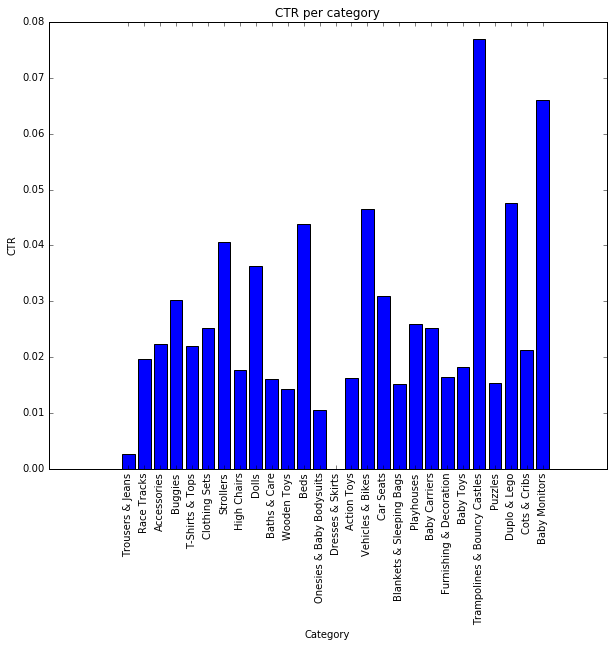

In [115]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

agg_thumb_counts = defaultdict(int)
agg_view_counts = defaultdict(int)

for item_id in thumb_counts:
    category_id = category_per_item[item_id]
    category_label = category_labels[category_id]
    agg_thumb_counts[category_label] += thumb_counts[item_id]

for item_id in view_counts:
    category_id = category_per_item[item_id]
    category_label = category_labels[category_id]
    agg_view_counts[category_label] += view_counts[item_id]

agg_ratios = {}
for category_label in category_labels.values():
    if agg_thumb_counts[category_label] > 0:
        agg_ratios[category_label] = agg_view_counts[category_label] / agg_thumb_counts[category_label] 

# Make a plot of the counts
bar_num_items = plt.bar(np.arange(len(agg_ratios)), agg_ratios.values(), color='b', align='center', label='# items')
plt.xticks(range(len(agg_ratios)), agg_ratios.keys())
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('CTR per category')
plt.xlabel('Category')
plt.ylabel('CTR')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)

plt.show()

Note that this plot gives another perspective on the categories, but is supplementary to the plot based on user activity. It is visible that toys are interesting categories. Baby stuff is not significant, but baby monitors is significant.